In [1]:
import os
import os.path as osp
import configparser
import pylab as py
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from typing import List

In [2]:
config_file_path = osp.join(os.getcwd(), 'config.ini')
parser = configparser.ConfigParser()
parser.read(config_file_path)
result_folder_path = parser['DATA_PATH']['result_path'] # Initialize result path

In [3]:
def load_results(dataset_result_path: str):
    result_file_paths = [osp.join(dataset_result_path, result_file_path) for result_file_path in os.listdir(dataset_result_path)]
    results = []
    for result_file_path in result_file_paths:
        result = pd.read_csv(result_file_path)
        results += result['balanced_accurary_score'].values.tolist()
    results = np.array(results)
    return results

In [4]:
def load_results_from_datasets(dataset_result_paths: List[str]):
    results = []
    for dataset_result_path in dataset_result_paths:
        results += load_results(dataset_result_path).tolist()
    results = np.array(results)
    return results

# Define function for data normality test

In [5]:
def shapiro_wilk_test(data):
    # Shapiro-Wilk test for normality
    shapiro = stats.shapiro(data)
    W, p = shapiro
    alpha = 0.05
    print("---> Shapiro-Wilk’s test...")
    print(f"test statistics: {W}, p-value: {p}")
    if p < alpha:
        print("The null hypothesis can be rejected --> Data is not normal!")
        return False
    else:
        print("The null hypothesis cannot be rejected --> Data is normal!")
    return True

In [6]:
def anderson_darling_test(data):
    # Anderson-Darling test for data coming from a particular distribution.
    anderson = stats.anderson(data)
    critical_value = anderson.critical_values[2] # alpha level = 0.05
    test_statistics = anderson.statistic
    print("---> Anderson-Darling test")
    print(f"test statistics: {test_statistics}")
    if test_statistics > critical_value:
        print("The null hypothesis can be rejected --> Data is not normal!")
        return False
    else:
        print("The null hypothesis cannot be rejected --> Data is normal!")
    return True

In [7]:
def visualize_data_distribution(data):
    plt.figure(figsize=(15, 6))
    
    # Plot histogram data distribution
    plt.subplot(121)
    plt.xlabel('Non-absolute difference of balanced accuracy score')
    plt.ylabel('Frequency of occurences')
    plt.hist(data, bins=25)

    # Plot QQ-plot
    plt.subplot(122)
    stats.probplot(data, dist='norm', plot=py)
    plt.show()

In [8]:
# Define one-sample sign test function
def one_sample_sign_test(data: np.array, population_median: float = 0.0, alternative: str = 'two-sided'):
    num_positive = sum(data > population_median)
    num_negative = sum(data < population_median)
    M = (num_positive - num_negative) / 2
    num_trials = num_positive + num_negative
    p_value = stats.binom_test([num_positive, num_negative], num_trials, p = 0.5, alternative = alternative) # The null hypothesis is that there is an equal number of signs (i.e. 50/50)
    return M, p_value

# RQ1.1 Analysis

## Does the personal-specific stress detection model achieve higher evaluation scores in predicting stress moments than a general cross-population stress detection model as used by the current generation of low-sampling-rate wearable devices?

## Load results for RQ1.1 Analysis

In [9]:
USE_SINGLE_DATASET = False

In [10]:
if USE_SINGLE_DATASET:
    # -- Uncomment the dataset that you wanna load -- #
    ### Only low-sampling-rate dataset is loaded
    dataset_name = 'AffectiveROAD'
    # dataset_name = 'DCU_NVT_EXP1'
    # dataset_name = 'WESAD_WRIST'

    # Load results of General 
    detector_type = 'General'
    general_result_path = osp.join(result_folder_path, dataset_name, detector_type)
    general_detector_results = load_results(general_result_path)

    # Load results of Personal
    detector_type = 'Personal'
    personal_result_path = osp.join(result_folder_path, dataset_name, detector_type)
    personal_detector_results = load_results(personal_result_path)
else:
    dataset_list = ["AffectiveROAD", 'DCU_NVT_EXP1', 'WESAD_WRIST']
    # Load results of General 
    detector_type = 'General'
    general_result_paths = [osp.join(result_folder_path, dataset_name, detector_type) for dataset_name in dataset_list]
    general_detector_results = load_results_from_datasets(general_result_paths)

    # Load results of Personal
    detector_type = 'Personal'
    personal_result_paths = [osp.join(result_folder_path, dataset_name, detector_type) for dataset_name in dataset_list]
    personal_detector_results = load_results_from_datasets(personal_result_paths)

In [11]:
# Compute non-absolute difference of balanced accuracy
# We assume that personal-specific model is statistically better than general cross-population model
non_absolute_diff = personal_detector_results - general_detector_results

## Data normality check

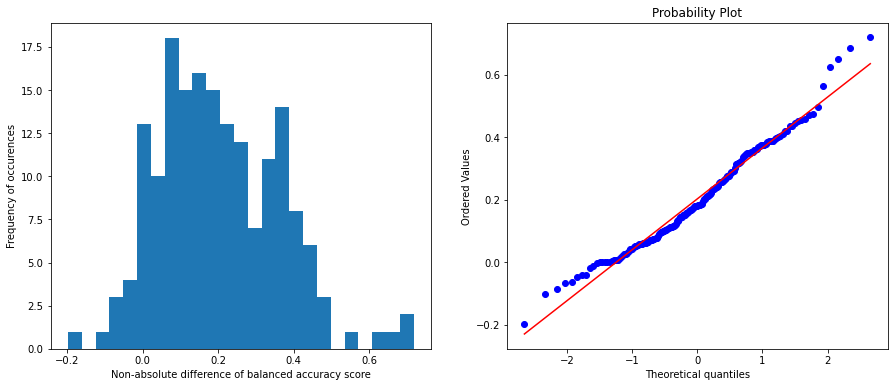

In [12]:
# Plot data distribution
visualize_data_distribution(non_absolute_diff)

In [13]:
# Check data normality to choose the proper hypothesis test
shapiro_wilk_result = shapiro_wilk_test(non_absolute_diff)
anderson_darling_result = anderson_darling_test(non_absolute_diff)

---> Shapiro-Wilk’s test...
test statistics: 0.9777888059616089, p-value: 0.006698196288198233
The null hypothesis can be rejected --> Data is not normal!
---> Anderson-Darling test
test statistics: 1.0657192527041843
The null hypothesis can be rejected --> Data is not normal!


## Null hypothesis: alpha = 0 (There is no statistical difference)
## Alternative hypothesis: alpha > 0 (Person-specific stress detector is statistical better than general cross-population detector)

In [14]:
num_observations = len(non_absolute_diff)
if shapiro_wilk_result & anderson_darling_result: # If the two tests confirm that the data is normal -> Use one-sample upper-tailed t-test
    population_mean = 0.0
    test_stats, p_value = stats.ttest_1samp(non_absolute_diff, population_mean)
    p_value /= 2
    effect_size = abs(stats.t.ppf(p_value, df = num_observations - 1)) / math.sqrt(num_observations)
    print(f"Test statistics: {test_stats} | p-value: {p_value}")
elif not shapiro_wilk_result | anderson_darling_result or not shapiro_wilk_result: # If the two tests confirm that the data is not normal -> Use One-sample sign test
    M, p_value = one_sample_sign_test(non_absolute_diff, alternative = 'greater')
    print(f"Test statistics {M} | p-value: {p_value}")

Test statistics 74.0 | p-value: 4.4248604154987907e-35


# RQ1.2 Analysis

## Can physiological signals recorded from wearable devices be used to develop a stress detection model for an individual?

## Load results for RQ1.2 Analysis

In [15]:
detector_type = 'Personal' # As we prove that using personal-specific stress detector is better

In [16]:
# Initialize WESAD_CHEST and WESAD_WRIST results
wesad_chest_path = osp.join(result_folder_path, 'WESAD_CHEST', detector_type)
wesad_wrist_path = osp.join(result_folder_path, 'WESAD_WRIST', detector_type)

# Combine results from different detectors and load them all
wesad_chest_results = load_results(wesad_chest_path)
wesad_wrist_results = load_results(wesad_wrist_path)

In [17]:
# Compute non-absolute difference of balanced accuracy
# We assume that wrist results are not statistically different from chest results
non_absolute_diff = wesad_chest_results - wesad_wrist_results

## Data normality check

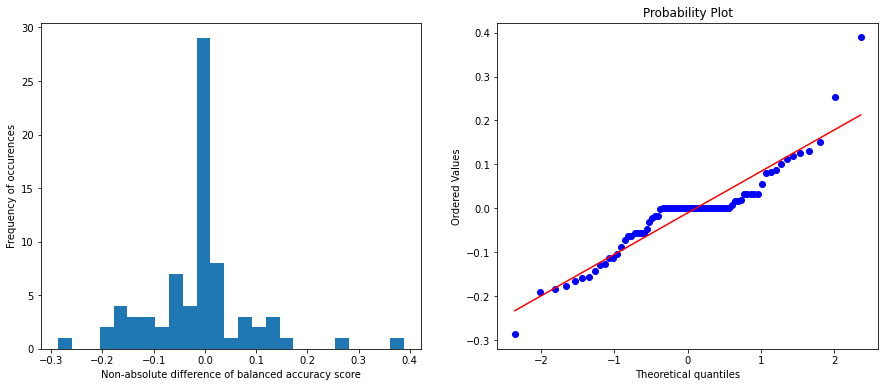

In [18]:
# Plot data distribution
visualize_data_distribution(non_absolute_diff)

In [19]:
# Check data normality to choose the proper hypothesis test
shapiro_wilk_result = shapiro_wilk_test(non_absolute_diff)
anderson_darling_result = anderson_darling_test(non_absolute_diff)

---> Shapiro-Wilk’s test...
test statistics: 0.9003586769104004, p-value: 2.2305730453808792e-05
The null hypothesis can be rejected --> Data is not normal!
---> Anderson-Darling test
test statistics: 2.9844056454350607
The null hypothesis can be rejected --> Data is not normal!


## Null hypothesis: alpha = 0 (There is no statistical difference)
## Alternative hypothesis: alpha != 0 (There is statistical difference)

In [20]:
num_observations = len(non_absolute_diff)
if shapiro_wilk_result & anderson_darling_result: # If the two tests confirm that the data is normal -> Use one-sample t-test
    population_mean = 0.0
    test_stats, p_value = stats.ttest_1samp(non_absolute_diff, population_mean)
    effect_size = abs(stats.t.ppf(p_value, df = num_observations - 1)) / math.sqrt(num_observations)
    print(f"Test statistics: {test_stats} | p-value: {p_value} | effect_size: {effect_size}")
elif not shapiro_wilk_result | anderson_darling_result: # If the two tests confirm that the data is not normal -> Use the one-sample sign test
    M, p_value = one_sample_sign_test(non_absolute_diff)
    print(f"Test statistics {M} | p-value: {p_value}")

Test statistics -3.0 | p-value: 0.47087901362171153
